<a id='Title'></a>

<a id='Title'></a>
# Energy Star Certification Eligibility and Score Models

Assignment for CASA0006: Data Science for Spatial Systems.

Student Number: 21197822

Code and Data available through Github Repo: https://github.com/sunny-netizen/CASA0006_Assessment.git

Some requirements to run this notebook include the following:

        ! pip install rfpimp
        ! pip install XGBoost

Libraries used in this notebook:

In [1]:
# Database and numerical libraries
import pandas as pd
import geopandas as gpd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
import rfpimp
from sklearn import model_selection #GridSearchCV for random forest
from sklearn import metrics
from sklearn.metrics import mean_squared_error

All models in this notebook use the same random state (rs = 99) for reproducibility:

In [2]:
# rs = random state
rs = 99

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Introduction'></a>
# Introduction
_Includes Literature Review and Research Questions._

In 2020, building operations contributed around 28 percent of total global energy-related C02 emissions ("2021 Global Status Report for Buildings and Construction"). Policymakers have encouraged and incentivised acquiring green building certificates, notably Energy Star and LEED, and their cost-saving and investment value-raising benefits as an strategy to reduce emissions and inefficient energy use in buildings. From 1999 to 2015, tens of thousands of new projects have gained these certificates (Qiu and Kahn, 2019). Interest in certification is likely to continue; for example, Abdallah, Muddana and Clevenger (2020) have explored optimisation models to assist large buildings in achieving green certifications. Adekanye, Davis and Azevedo (2020) find that the synergy of federal policy, local policy, and improvements to certification rating systems further drive certification. 

However, researchers have also investigated if certification actually leads to energy savings and other value benefits. For example, Qiu and Kahn (2019) find that Energy Star building occupants reduce monthly energy consumption by 8%, lower compared to previous studies, and that Energy Star points are not necessarily related to energy savings. In other words, the results are mixed. On the other hand, Leskinen, Vimpari and Junnila (2020) reviewed that green certificates likely have a positive impact on property cash flows and values, including some indication that they increase rent and sale premiums and occupancy rates and decrease operating expenses and risk (their review found most studies to be from the U.S.). Whether or not the energy savings are real, certificates seem valuable in the milieu of responsible property investing and investing amidst environmental risks (Leskinen, Vimpari and Junnila, 2020). 

Beyond the potential benefits, local policy may require engagement with green certification metrics. The Existing Buildings Energy & Water Efficiency (EBEWE) Program in the City of Los Angeles was established in 2016 with an aim to reduce water and energy consumption and greenhouse gas emissions (LADBS, 2022). Buildings that are required to register and report their benchmarking data, using Energy Star Portfolio Manager, include City-owned buildings and privately owned buildings with gross floor areas above certain sizes (7,500 square feet and 20,000 square feet, respectively) ("Benchmark Compliance Instructions for 2021"). The City of Los Angeles' DataHub provides a rich dataset of energy and water efficiency data and certification information for major buildings in relating to this program. One of the major reportings in the EBEWE dataset are ENERGY STAR scores and certification information. 

Energy Star is a green certification in the United States and Canada. The Energy Star score (1 - 100) reflects a building's energy efficiency relative to all buildings in its property type nation-wide, comparing against perioidic national survey data ("How the 1-100 ENERGY STAR Score is Calculated"). A score of 50 represents the national median, while a score of 75 or higher qualifies a building for Energy Star certification ("Glossary"). Receiving a score requires 12 calendar months of energy data and property use information ("Portfolio Manager: What data is required to benchmark your property?"). 

The aim of this report is to build some tools to help these large buildings registered in the EBEWE Program to gauge their Energy Star performance.  Although applying for the Energy Star certification is free, professional verification may incur fees around 1500 USD per building unless pro-bono services can be accessed. The first tool will predict the Energy Star score. The second tool will predict the Energy Star Certification. These may be useful for those who wish to estimate their score and eligibility without using the Energy Star Portfolio or for those who wish to simulate improving their metrics to achieve Energy Star goals. Both tools will be built on decision tree and ensemble methods. 

<a id='Research_Question'></a>
### Research Question

    Research Objective 1: Are factors in the EBEWE dataset sufficient to build a model to predict the energy star score of large buildings in Los Angeles? Which factors have the strongest influence in machine learning models? Which machine learning models have the best performance?

    Research Objective 2: Are factors in the EBEWE dataset sufficient to build a model to predict if a large building Los Angeles may receive an Energy Star Certification? Which factors have the strongest influence in machine learning models? Which machine learning models have the best performance?

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Methodology'></a>
# Methodology

This report will use supervised machine learning methods, decision trees and ensemble learning, to accomplish the research objectives for building Energy Star tools for EBEWE buildings, employing regression for Research Objective 1 to predict the continuous values of Energy Star scores and classification for Research Objective 2 to predict the the discrete cateories of certification or not. Decision trees are flexible, robust to noise, able to handle redundant attributes and have lower computational cost (Jena and Dehuri, 2019, pp.405). They are straightforward to interpret and visualise but prone to overfitting, and are unstable unless deployed within an ensemble ("1.10 Decision Trees"). The CART algorithm used in the scikit-learn Python library for decision trees is accurate and biased towards distinct values (Jena and Dehuri, 2019, pp.416). CART is flexible and interpretable especially for simple trees but lack smoothness, whereas ensemble methods, such as bagging (random forest with hyperparameter optimisation) and boosting (gradient boosting decision trees), are more difficult to interpret, but they generally have better generalisation and less overfitting (CASA0009 Lecture 6). 

Previous studies have used machine learning models to predict building energy use metrics. For example, Robinson et al. (2017) found gradient boosting regression models (XGBoost from scikit-Learn Python library) superior to other methods, such as Linear regression and SVM, in predicting US commercial building energy consumption using variables characterising building conditions. 
Meanwhile, Jin et al. (2022) build a benchmarking framework for building energy performance, including with random forests. The use of decision trees and random forests in these studies suggest the potential for these methods in modeling building energy use-related predictions, although the variables from the EBEWE dataset are distinct even though thematically similar. 

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Preprocessing'></a>
# Preprocessing

This report uses the April 24th, 2022 update of the EBEWE Program dataset downloaded from the [City of Los Angeles Data Catalog](https://data.lacity.org/City-Infrastructure-Service-Requests/Existing-Buildings-Energy-Water-Efficiency-EBEWE-P/9yda-i4ya). The dataset contains 52307 rows of data, each row representing one address, potentially representing more than one building structure. There are 28 columns of features, including those relating to greenhouse gas emissions, Energy Star scoring, EBEWE program status, building traits, water usage, and energy usage. 

In [3]:
#Load EBEWE Program dataset
df = pd.read_csv("Existing_Buildings_Energy___Water_Efficiency__EBEWE__Program.csv",  na_values=['Not Available', '', 'NaN'])
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Have a look at the data
df.head()

Dataset contains 52307 rows and 28 columns.


,BUILDING ADDRESS,BUILDING ID,CARBON DIOXIDE EMISSIONS (Metric Ton CO2e),COMPLIANCE STATUS,% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI,% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI,ENERGY STAR SCORE,ENERGY STAR CERTIFICATION - ELIGIBILITY,ENERGY STAR CERTIFICATION - LAST APPROVAL DATE,ENERGY STAR CERTIFICATION - YEAR(S) CERTIFIED,...,PROGRAM YEAR,PROPERTY TYPE,SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²),Source EUI (kBtu/ft²),TOTAL WATER USE (kgal),WEATHER NORMALIZED SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²),WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY (EUI) (kBtu/ft²),YEAR BUILT,AIN,LADBS Building Category
0,5900 SEPULVEDA BLVD,420859887322,179.8,NOT COMPLIED,-62.1,-62.1,95.0,No,NaN,NaN,...,2021,Office,25.1,68.9,1091.4,24.6,67.6,1981.0,019,"50,000 to 99,999 sqft"
1,10515 VALPARAISO ST,436227833558,89.9,COMPLIED,-20.6,-20.6,81.0,Yes,NaN,NaN,...,2021,Multifamily Housing,40.1,60.9,1624.8,39.3,60.0,1959.0,001,"20,000 to 49,999 sqft"
2,11340 W OLYMPIC BLVD,427804836294,170.6,COMPLIED,-47.8,-47.8,90.0,Yes,NaN,NaN,...,2020,Office,30.3,84.9,1052.3,NaN,NaN,1975.0,017,"50,000 to 99,999 sqft"
3,3071 LEEWARD AVE,473519843970,58.1,COMPLIED,-6.7,-6.7,60.0,No,NaN,NaN,...,2021,Multifamily Housing,49.0,69.3,2923.4,49.0,69.3,1927.0,013,"20,000 to 49,999 sqft"
4,1615 N MARTEL AVE,455587859077,33.5,COMPLIED,-52.8,-52.8,100.0,No,NaN,NaN,...,2020,Multifamily Housing,20.0,40.3,837.1,20.0,40.3,1961.0,015,"20,000 to 49,999 sqft"


Identify the number of NA's throughout the dataset by looking in each column:

In [4]:
# create an empty dictionary
nas = dict()

# add column names names and number of NA's to dictionary
for col in list(df.columns):
    nas[col] = df[col].isnull().sum()

# convert dictionary to pandas dataframe
dna = pd.DataFrame.from_dict(nas, orient='index', columns=['NAs'])
print(dna)
print()

                                                      NAs
BUILDING ADDRESS                                        0
BUILDING ID                                             0
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)          27037
COMPLIANCE STATUS                                       0
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI        29483
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI          29483
ENERGY STAR SCORE                                   35115
ENERGY STAR CERTIFICATION - ELIGIBILITY             26062
ENERGY STAR CERTIFICATION - LAST APPROVAL DATE      51399
ENERGY STAR CERTIFICATION - YEAR(S) CERTIFIED       51399
ENTITY RESPONSIBLE FOR BENCHMARK                    26001
GROSS BUILDING FLOOR AREA (ft²)                     26001
INDOOR WATER USE (kgal)                             48468
INDOOR WATER USE INTENSITY (gal/ft²)                48479
NUMBER OF BUILDINGS                                 26001
OCCUPANCY                                           26001
OUTDOOR WATER 

Drop columns that are inadequate or irrelevant for further analysis, including columns with more than 40000 NA's and some others that would contribute numerous categorical factors.

In [5]:
df2 = df.drop(labels = [
    # Columns with over 40000 NA's
    'ENERGY STAR CERTIFICATION - LAST APPROVAL DATE',
    'ENERGY STAR CERTIFICATION - YEAR(S) CERTIFIED',
    'INDOOR WATER USE (kgal)',
    'INDOOR WATER USE INTENSITY (gal/ft²)',
    'OUTDOOR WATER USE (kgal)', 
    
    # Columns not of interest
    'ENTITY RESPONSIBLE FOR BENCHMARK',
    'AIN',
    'BUILDING ADDRESS'], axis = 1)

Drop any rows with remaining NA's. About 30.3% of the original dataset remains for analysis. Assign 'BUILDING ID' as the row index.

In [6]:
df2.dropna(inplace = True, axis = 0)
df2.set_index("BUILDING ID", inplace = True)
print(f"Dataset now contains {df2.shape[0]} rows and {df2.shape[1]} columns. {round(100*15852/52307, 1)}% of the original data entries remain for analysis.")
print()
print("Remaining columns are:")
print(list(df2.columns))
print()
print()

Dataset now contains 15852 rows and 19 columns. 30.3% of the original data entries remain for analysis.

Remaining columns are:
['CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)', 'COMPLIANCE STATUS', '% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI', '% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI', 'ENERGY STAR SCORE', 'ENERGY STAR CERTIFICATION - ELIGIBILITY', 'GROSS BUILDING FLOOR AREA (ft²)', 'NUMBER OF BUILDINGS', 'OCCUPANCY', 'POSTAL CODE', 'PROGRAM YEAR', 'PROPERTY TYPE', 'SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)', 'Source EUI (kBtu/ft²)', 'TOTAL WATER USE (kgal)', 'WEATHER NORMALIZED SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)', 'WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY (EUI) (kBtu/ft²)', 'YEAR BUILT', 'LADBS Building Category']




In [7]:
df2.dtypes

CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)                         float64
COMPLIANCE STATUS                                                   object
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI                       float64
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI                         float64
ENERGY STAR SCORE                                                  float64
ENERGY STAR CERTIFICATION - ELIGIBILITY                             object
GROSS BUILDING FLOOR AREA (ft²)                                    float64
NUMBER OF BUILDINGS                                                float64
OCCUPANCY                                                          float64
POSTAL CODE                                                          int64
PROGRAM YEAR                                                         int64
PROPERTY TYPE                                                       object
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)                         float64
Source EUI (kBtu/ft²)    

Reorder remaining columns thematically for convenience.

In [8]:
df3 = df2.reindex(columns=[
    
        # Building traits
        'POSTAL CODE',
        'YEAR BUILT',
        'GROSS BUILDING FLOOR AREA (ft²)',
        'NUMBER OF BUILDINGS',
        'PROPERTY TYPE',
        'LADBS Building Category',
        
        # EBEWE status
        'OCCUPANCY',
        'PROGRAM YEAR',
        'COMPLIANCE STATUS',
        
        # Other metrics
        'CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)',
        'TOTAL WATER USE (kgal)',
        
        # Energy use intensity metrics
        'SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)',
        'Source EUI (kBtu/ft²)',
        'WEATHER NORMALIZED SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)',
        'WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY (EUI) (kBtu/ft²)',

        # Energy Star score-related data
        '% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI',
        '% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI',
        'ENERGY STAR SCORE',
        'ENERGY STAR CERTIFICATION - ELIGIBILITY'
])

It turns out that some columns contain French entries. Translate French entries into English using regex to avoid redundant categories.

In [9]:
print("The 'Energy Star Certification - Eligibility' Column contains these unique values:",
      df3['ENERGY STAR CERTIFICATION - ELIGIBILITY'].unique())
df3['ENERGY STAR CERTIFICATION - ELIGIBILITY'].replace(['Oui', 'Non'], ['Yes', 'No'], inplace=True)
print("After cleaning it contains:", df3['ENERGY STAR CERTIFICATION - ELIGIBILITY'].unique())
print()
print("The 'Property Type' column contains these unique values:", df3['PROPERTY TYPE'].unique())
df3['PROPERTY TYPE'].replace(r'Immeuble.*$', 'Multi-dwelling building', regex=True, inplace=True)
print("After cleaning it contains:", df3['PROPERTY TYPE'].unique())
print()

The 'Energy Star Certification - Eligibility' Column contains these unique values: ['No' 'Yes' 'Oui' 'Non']
After cleaning it contains: ['No' 'Yes']

The 'Property Type' column contains these unique values: ['Office' 'Multifamily Housing' 'Distribution Center'
 'Non-Refrigerated Warehouse' 'Immeuble à logements multiples' 'Hotel'
 'Worship Facility' 'K-12 School' 'Senior Living Community'
 'Supermarket/Grocery Store' 'Medical Office' 'Retail Store'
 'Refrigerated Warehouse' 'Wholesale Club/Supercenter' 'Data Center'
 'Financial Office' 'Mixed Use Property' 'Senior Care Community'
 'Residence Hall/Dormitory' 'Bank Branch'
 'Hospital (General Medical & Surgical)' 'Other'
 'Other - Lodging/Residential' 'Manufacturing/Industrial Plant'
 'Immeuble � logements multiples' 'Bureau' 'Courthouse']
After cleaning it contains: ['Office' 'Multifamily Housing' 'Distribution Center'
 'Non-Refrigerated Warehouse' 'Multi-dwelling building' 'Hotel'
 'Worship Facility' 'K-12 School' 'Senior Living Commun

In [10]:
# Check columns and datatypes
df3.dtypes

POSTAL CODE                                                          int64
YEAR BUILT                                                         float64
GROSS BUILDING FLOOR AREA (ft²)                                    float64
NUMBER OF BUILDINGS                                                float64
PROPERTY TYPE                                                       object
LADBS Building Category                                             object
OCCUPANCY                                                          float64
PROGRAM YEAR                                                         int64
COMPLIANCE STATUS                                                   object
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)                         float64
TOTAL WATER USE (kgal)                                             float64
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)                         float64
Source EUI (kBtu/ft²)                                              float64
WEATHER NORMALIZED SITE E

Transform categorical variables into individual features with numerical binaries using One Hot Encoding. One Hot Encoding is used instead of direct vectorizer because it is compatible with Permutation Feature Importance, which will be used later.

In [11]:
# One Hot Encoding
hot = pd.get_dummies(df3)

# See new columns
hot.dtypes

POSTAL CODE                                                               int64
YEAR BUILT                                                              float64
GROSS BUILDING FLOOR AREA (ft²)                                         float64
NUMBER OF BUILDINGS                                                     float64
OCCUPANCY                                                               float64
PROGRAM YEAR                                                              int64
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)                              float64
TOTAL WATER USE (kgal)                                                  float64
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)                              float64
Source EUI (kBtu/ft²)                                                   float64
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)           float64
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY (EUI) (kBtu/ft²)         float64
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE

Prepare data for machine learning models by separating the target variable from the data. The target feature for classification is 'ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes', and the target feature for regression is 'ENERGY STAR SCORE'. These target data should be removed from the feature data. 

Remove 'ENERGY STAR CERTIFICATION - ELIGIBILITY_No' from the feature data as well, since it is directly correlated with the target classification data.

Also remove 'POSTAL CODE' because location is not a feature of interest because it is not a factor that building owners can change or improve to increase their energy efficiency; it may even be unethical to bias calculators for certification eligibility and scoring to location.

In [12]:
data_x = hot.drop('POSTAL CODE', axis=1).drop('ENERGY STAR SCORE', axis=1).drop('ENERGY STAR CERTIFICATION - ELIGIBILITY_No', axis=1).drop('ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes', axis=1)
label_y = hot['ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes']
regr_y = hot['ENERGY STAR SCORE']

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Presentation_of_Data'></a>
# Presentation of Data

Data distributions for the target datasets are as follows:

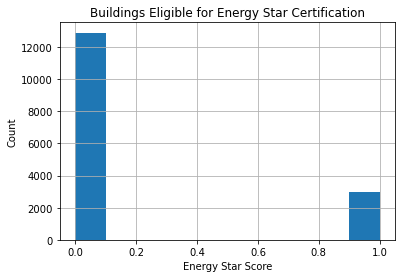

In [13]:
label_y.hist();
plt.title('Buildings Eligible for Energy Star Certification');
plt.xlabel('Energy Star Score');
plt.ylabel('Count');

Upon inspection, the data for this classification target data is subject to the Accuracy Paradox because the class distribution is imbalanced. Only about 23% of the buildings are eligible for Energy Star certification:

In [14]:
print("The ratio of eligible to ineligible is:", 2963/12889)
label_y.value_counts()

The ratio of eligible to ineligible is: 0.22988594925905811


0    12889
1     2963
Name: ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes, dtype: int64

This means that the classification model may be better at predicting ineligible buildings rather than eligible buildings and that it will be important to compare both the accuracy and F1 scores when evaluating the model's prediction capabilities.

As for the regression target data distribution:

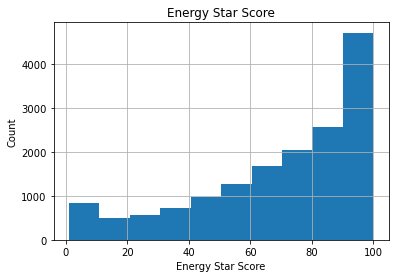

In [15]:
regr_y.hist();
plt.title('Energy Star Score');
plt.xlabel('Energy Star Score');
plt.ylabel('Count');

Energy Star Scores have a left skew; understandable, as more buildings become more energy efficient, the data will accumulate close to, 100 which is the maximum score.

Below are data distributions for the feature data excluding non-categorical variables (which would all have values of 0 or 1):

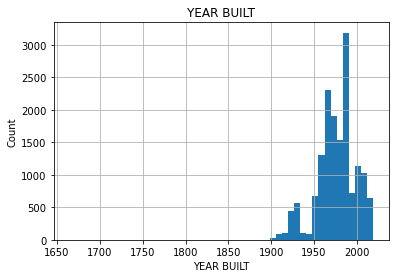

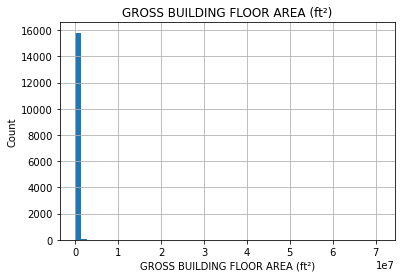

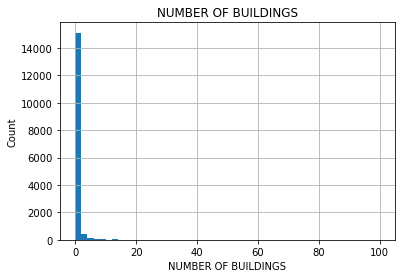

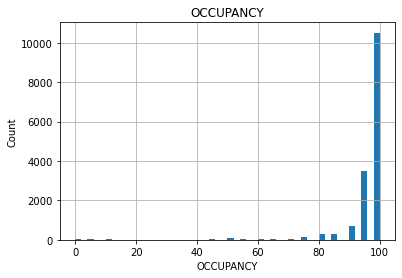

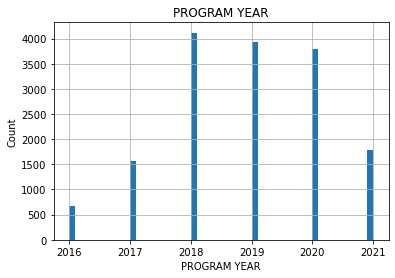

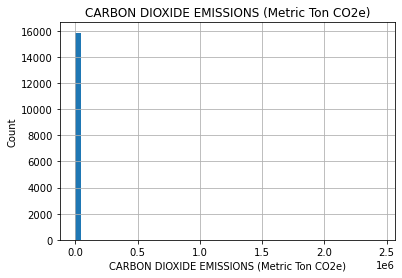

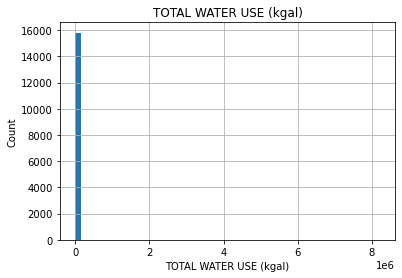

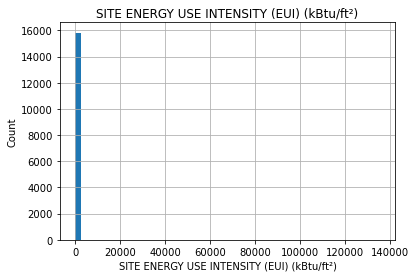

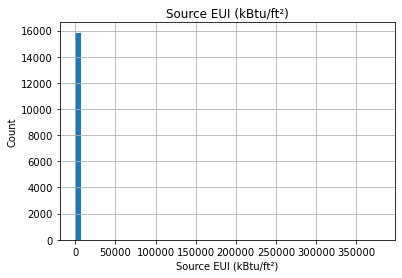

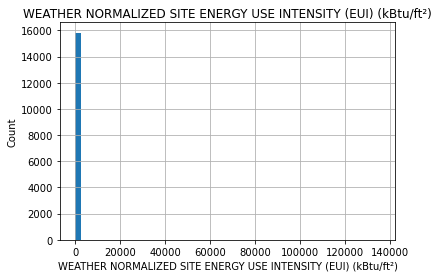

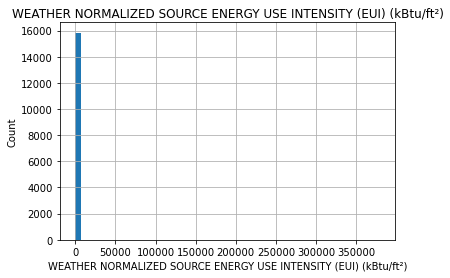

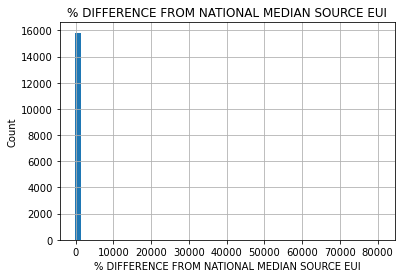

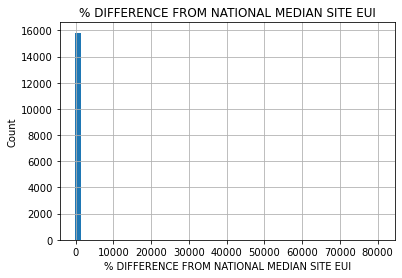

In [16]:
for i in data_x.columns[0:13]:
    data_x.hist(i, bins=50);
    plt.xlabel(i);
    plt.ylabel('Count');

Most of the variables are skew or have extreme outliers. Fortunately, all of the tree-based and ensemble methods used will have no assumptions on data distribution and can work with non-linear relationships and feature interactions, therefore they are robust to highly skewed data and outliers and data transformations are unnecessary. 

Visualise the data cartographically by merging with zipcode geometry downloaded from the [County of Los Angeles Open Data Catalog](https://data.lacounty.gov/Geospatial/ZIP-Codes/65v5-jw9f):

In [17]:
# Load the zipcode geometry
zipcodes = gpd.read_file("ZIP Codes.geojson")
zipcodes = gpd.GeoDataFrame(zipcodes, geometry='geometry', crs = 4326)
#Check its data
zipcodes.head()

,objectid,shape_area,shape_len,zipcode,geometry
0,1,95563401.532,48677.2784778,90001,"MULTIPOLYGON (((-118.24337 33.98923, -118.2433..."
1,2,82752224.0145,44972.0170345,90002,"MULTIPOLYGON (((-118.23429 33.96101, -118.2342..."
2,3,102660026.575,63294.5763958,90003,"MULTIPOLYGON (((-118.27392 33.98934, -118.2739..."
3,4,83956967.2341,52471.8976347,90004,"MULTIPOLYGON (((-118.28409 34.08348, -118.2842..."
4,5,36897792.3428,88445.0017476,90005,"MULTIPOLYGON (((-118.33650 34.06189, -118.3355..."


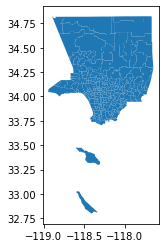

In [18]:
# Test plot just the zipcode geometry
zipcodes.plot();

In [19]:
#Check that join columns have the same datatypes
print(hot['POSTAL CODE'].dtypes, "is not the same as", zipcodes['zipcode'].dtypes)

#Since they are different, make them the same type
zipcodes['zipcode'] = zipcodes['zipcode'].astype('int64')

print(hot['POSTAL CODE'].dtypes, "is the same as", zipcodes['zipcode'].dtypes)

int64 is not the same as object
int64 is the same as int64


In [20]:
# need to aggregate on zipcode
agg_bld = hot.groupby('POSTAL CODE').count()
agg_score = hot.groupby('POSTAL CODE').mean('ENERGY STAR SCORE')
agg_cert = hot.groupby('POSTAL CODE').sum('ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes')
agg_cert['ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes'] = agg_cert['ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes']/agg_bld['YEAR BUILT']

For zipcodes with buildings with sufficient EBEWE data, map and graph the number of EBEWE buildings:

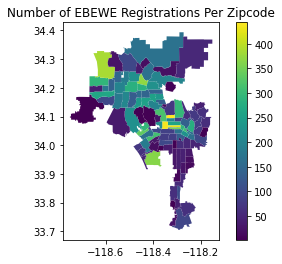

In [21]:
# Merge geometry and data using the intersection method to exclude zipcodes outside of the City of Los Angeles.
gdf_bld = pd.merge(agg_bld, zipcodes, 'inner', left_on ='POSTAL CODE', right_on = 'zipcode')
gdf_bld = gpd.GeoDataFrame(gdf_bld, geometry='geometry', crs = 4326)
gdf_bld.plot(column = 'ENERGY STAR SCORE', cmap = 'viridis', legend = True);
plt.title('Number of EBEWE Registrations Per Zipcode');

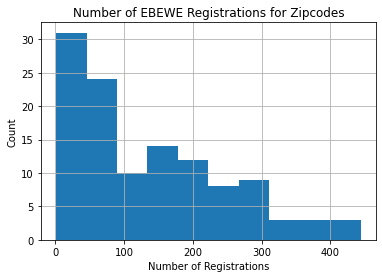

In [22]:
gdf_bld.hist('ENERGY STAR SCORE');
plt.title('Number of EBEWE Registrations for Zipcodes');
plt.xlabel('Number of Registrations');
plt.ylabel('Count');

The number of registered buildings throughout the zipcodes of the City of Los Angeles have a right-tailed distribution, where more zipcodes have fewer registrations. This is reflected in the predominance of darker hues on the map. The few lighter areas on the map may correspond to dense city centers with more buildings. 

For zipcodes with buildings with sufficient EBEWE data, map and graph the average Energy Star Scores for EBEWE buildings: 

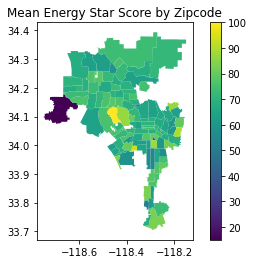

In [23]:
# Merge geometry and data using the intersection method to exclude zipcodes outside of the City of Los Angeles.
gdf_score = pd.merge(agg_score, zipcodes, 'inner', left_on ='POSTAL CODE', right_on = 'zipcode')
gdf_score = gpd.GeoDataFrame(gdf_score, geometry='geometry', crs = 4326)
gdf_score.plot(column = 'ENERGY STAR SCORE', cmap = 'viridis', legend = True);
plt.title('Mean Energy Star Score by Zipcode');

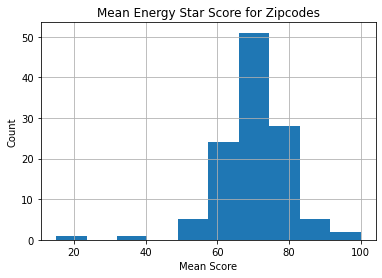

In [24]:
gdf_score.hist('ENERGY STAR SCORE');
plt.title('Mean Energy Star Score for Zipcodes');
plt.xlabel('Mean Score');
plt.ylabel('Count');

The lighter green hues on the map indicate that more zipcodes have medium high mean scores. Thisi s reflected in the plot, which has a bell curve distribution with a peak around 70 as the mean Energy Star Score.


For zipcodes with buildings with sufficient EBEWE data, map and graph the total number of buildings eligible for Energy Star Scores for EBEWE buildings. It appears that only a few zipcodes have higher numbers.

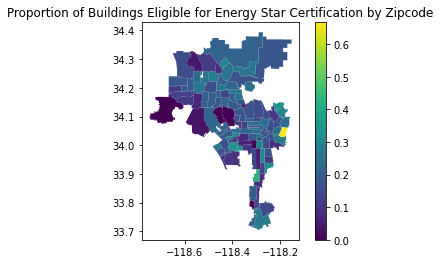

In [25]:
# Merge geometry and data using the intersection method to exclude zipcodes outside of the City of Los Angeles.
gdf_cert = pd.merge(agg_cert, zipcodes, 'inner', left_on ='POSTAL CODE', right_on = 'zipcode')
gdf_cert = gpd.GeoDataFrame(gdf_cert, geometry='geometry', crs = 4326)
gdf_cert.plot(column = 'ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes', cmap = 'viridis', legend = True);
plt.title('Proportion of Buildings Eligible for Energy Star Certification by Zipcode');

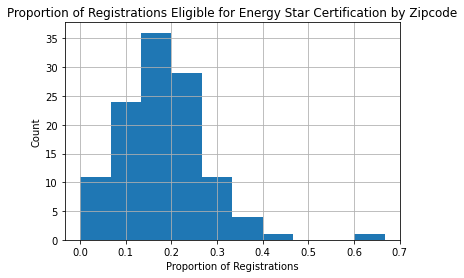

In [26]:
gdf_cert.hist('ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes');
plt.title('Proportion of Registrations Eligible for Energy Star Certification by Zipcode');
plt.xlabel('Proportion of Registrations');
plt.ylabel('Count');

Most zipcodes have a low proportion of certification eligible buildings, as shown by the predominance of darker hues in the map. Some centrally located zipcodes have slightly higher proportions. The proportions are distributed in a bell curve, as seen in the chart. Interestingly, the eligibility and Energy Star Score maps do not appear strongly correlated. Eligibility and score may not be correlated by zipcode location.

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='ResultsClassification'></a>
# Results & Discussion: Certification Eligibility

Separate and reserve 25% of the feature data and classification target data for testing.

In [27]:
train_d, test_d, train_lab, test_lab = train_test_split(data_x, label_y, random_state=rs)

In [28]:
# Check size of new data splits
len(train_d),len(train_lab),len(test_d), len(test_lab)

(11889, 11889, 3963, 3963)

The class distribution imbalance is retained in the test and training sets:

In [29]:
label_y.value_counts(), train_lab.value_counts(), test_lab.value_counts()

(0    12889
 1     2963
 Name: ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes, dtype: int64,
 0    9664
 1    2225
 Name: ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes, dtype: int64,
 0    3225
 1     738
 Name: ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes, dtype: int64)

In [30]:
print("The ratios are:", 2963/12889, ",", 2225/9664, ",",738/3225)

The ratios are: 0.22988594925905811 , 0.2302359271523179 , 0.2288372093023256


[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='ClassificationTree'></a>
## Classification Tree
The Decision Tree Classifier from scikit-learn is a decision tree employing the CART algorithm. This report uses it to model the EBEWE Energy Star certification eligibility data:

In [31]:
# instantiate estimator
tree_clf = DecisionTreeClassifier(random_state=rs)

# fit model to training data
tree_clf.fit(train_d, train_lab)

# apply the model on the test set
tree_clf_predictions = tree_clf.predict(test_d)

Check the performance accuracy of the classifier on the training and test set:

In [32]:
print("The accuracy of this classifier on the train data is: {}".format(tree_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is: {}".format(tree_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is: 0.9999158886365548
The accuracy of this classifier on the test data is: 0.8523845571536715


The classifier is much more accurate on the training data than on the test data. This discrepancy indicates potential overfitting, which is common for CART. 

A confusion matrix further visualises prediction performance metrics:

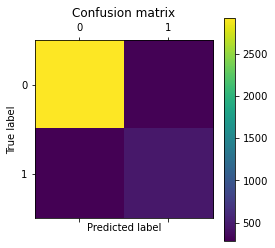

In [33]:
confusion_matrix__tree_clf = metrics.confusion_matrix(test_lab, tree_clf_predictions)
plt.matshow(confusion_matrix__tree_clf)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The black squares in the confusion matrix represent that there both false positives and false negatives are fewer than 500. The tan square represents around 3000 false positives, and the purple square represents around 1000 true positives. This 3:1 ratio is the same as the ratio of ineligible buildings to eligible buildings in the class distribution.

A classification report calculates further metrics:

In [34]:
metrics__tree_clf = metrics.classification_report(test_lab, tree_clf_predictions)
print (metrics__tree_clf)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3225
           1       0.60      0.61      0.61       738

    accuracy                           0.85      3963
   macro avg       0.76      0.76      0.76      3963
weighted avg       0.85      0.85      0.85      3963



The results are consistent with expectations. Precision is the number of correct positive predictions out of all positive predictions; the proportion of predictions that are correct. Recall is the number of correct predictions out of all positive occurrances; the proportion of classifications that are correct. The F1 score takes both precision and recall into account. All three of these metrics have similar results, with the eligible class scoring around 0.60-0.62, and the ineligible class scoring 0.91. As anticipated, the ineligible class has greater accuracy overall due to its greater class distribution; for the first two rows of the classification report, the "support" column shows the true number of occurrances for each class in the test data, while for the last three columns it provides the true number of occurances in the test data. This reflects the Accuracy Paradox at play. The F1-score for positive predictions is 0.61, lower than the overall accuracy metric of 0.85; the latter should thus not be taken at face value. 

Next, the tree structure includes:

In [35]:
print("Depth of the regression tree: {}".format(tree_clf.get_depth()))
print("Number of nodes of this tree: {}".format(tree_clf.get_n_leaves()))

Depth of the regression tree: 29
Number of nodes of this tree: 1061


Since this tree has more than 20 layers and hundreds of leaves, the Permutation Feature Importance (PFI) will be more useful than visualising the tree. PFI is based on how much the model error is impacted by shuffling values each feature, and it reveals the importance of specific features/variables in the model.

In [36]:
# Permutation Feature Importance (PFI) 
imp__tree_clf = rfpimp.importances(tree_clf, test_d, test_lab) # permutation
print(imp__tree_clf)

                                                    Importance
Feature                                                       
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI          0.125662
PROGRAM YEAR                                          0.072168
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI            0.054504
PROPERTY TYPE_Multifamily Housing                     0.036336
Source EUI (kBtu/ft²)                                 0.031289
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)            0.021953
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)            0.019177
YEAR BUILT                                            0.017663
GROSS BUILDING FLOOR AREA (ft²)                       0.015645
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...    0.013626
OCCUPANCY                                             0.012869
TOTAL WATER USE (kgal)                                0.009589
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (E...    0.009084
PROPERTY TYPE_Non-Refrigerated Warehouse              0

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


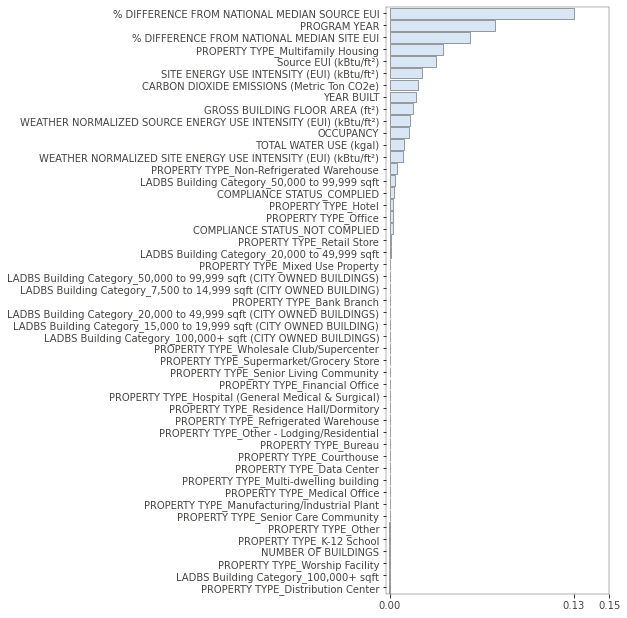

In [37]:
# Visualise PFI
viz_imp__tree_clf = rfpimp.plot_importances(imp__tree_clf)
viz_imp__tree_clf.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='ClassificationForest'></a>
## Random Forest Classifier

The Random Forest Classifier from scikit-learn is a bagging ensemble method using decision trees (CART) as a basic unit. This report uses it to model the EBEWE Energy Star certification eligibility data.

A cross-validated grid-search will first identify more optimal hyperparameters. The following two blocks are commented out to avoid running due to the lengthy computation time, but their results are provided. 

<!-- %%time

# values of max_depth. 6 values ranging from 10 to 100
list_max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]

# values of n_estimators
list_n_estimators = [50, 100, 200, 300, 400]

# create a grid of the two hyperparameters
grid_hyperparameters = {'n_estimators':list_n_estimators,
                       'max_depth': list_max_depth}

# select the model and its hyperparameters
forest_clf_grid = RandomForestClassifier(random_state = rs)

# initiate and fit model
grid_clf = model_selection.GridSearchCV(forest_clf_grid, grid_hyperparameters)
grid_clf.fit(train_d, train_lab) -->

Results:

CPU times: user 6min 24s, sys: 1.95 s, total: 6min 26s, Wall time: 6min 35s
GridSearchCV(estimator=RandomForestClassifier(random_state=99),param_grid={'max_depth': [10, 30, 50, 70, 90, 110],'n_estimators': [50, 100, 200, 300, 400]})

<!-- # query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (grid_clf.best_params_)
print ("The best score is: ")
print (grid_clf.best_score_) -->

Results:
The best parameter value is: 
{'max_depth': 50, 'n_estimators': 400}.
The best score is: 
0.8925903307311837.

Then the classifier will be initialized with the optimal hyperparameters, fit to the training data, and used to predict eligibility classes for test data. 

In [38]:
# instantiate estimator
forest_clf = RandomForestClassifier(random_state = rs) #, max_depth = 50, n_estimators = 400)

# fit model to training data
forest_clf.fit(train_d,train_lab)

# apply the model to test data
forest_clf_predictions = forest_clf.predict(test_d)

In [39]:
print("The accuracy of this classifier on the train data is: {}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is: {}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is: 0.9999158886365548
The accuracy of this classifier on the test data is: 0.897300025233409


Compared to the decision tree results, the accuracy on the test data has improved and the gap between the accuracy of the training and test sets has decreased, suggesting that there is less overfitting for random forest, as expected for an ensemble method.

A confusion matrix further visualises prediction performance metrics:

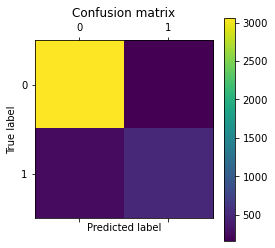

In [40]:
confusion_matrix__forest_clf = metrics.confusion_matrix(test_lab, forest_clf_predictions)
plt.matshow(confusion_matrix__forest_clf)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The random forest classifier confusion matrix appears similar to the decision tree classifier confusion matrix in having many true negatives, some true positives, and very few false negatives and false positives.

In [41]:
metrics__forest_clf = metrics.classification_report(test_lab, forest_clf_predictions)
print (metrics__forest_clf)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3225
           1       0.75      0.67      0.71       738

    accuracy                           0.90      3963
   macro avg       0.84      0.81      0.82      3963
weighted avg       0.89      0.90      0.89      3963



Both eligibility precision and recall, especially precision, have increased compared to the decision tree results. This greater precision means that there is a greater proportion of eligibility predictions that are correct. In other words, there are fewer false positives, and slightly fewer false negatives. While accuracy, 0.90, and the f1-score of the eligible class, 0.71, have both improved compared to the decision tree results, but their gap, indicating the Accuracy Paradox, is still present. It appears that the random forest classifier is an improved model over decision tree classifier, but it does not mitigate the Accuracy Paradox, which would require reducing the proportion of false negatives.  

This model is too complex to visualise, but the Permutation Feature Importance (PFI) can again show the importance of each feature/variable in the model:

In [42]:
# Permutation Feature Importance (PFI) 
imp__forest_clf = rfpimp.importances(forest_clf, test_d, test_lab) # permutation
print(imp__forest_clf)

                                                    Importance
Feature                                                       
PROGRAM YEAR                                          0.079233
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI          0.037850
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI            0.034570
PROPERTY TYPE_Multifamily Housing                     0.025233
YEAR BUILT                                            0.011355
OCCUPANCY                                             0.009841
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...    0.004290
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)            0.004290
COMPLIANCE STATUS_COMPLIED                            0.004037
COMPLIANCE STATUS_NOT COMPLIED                        0.004037
Source EUI (kBtu/ft²)                                 0.004037
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (E...    0.003280
GROSS BUILDING FLOOR AREA (ft²)                       0.003028
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)            0

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


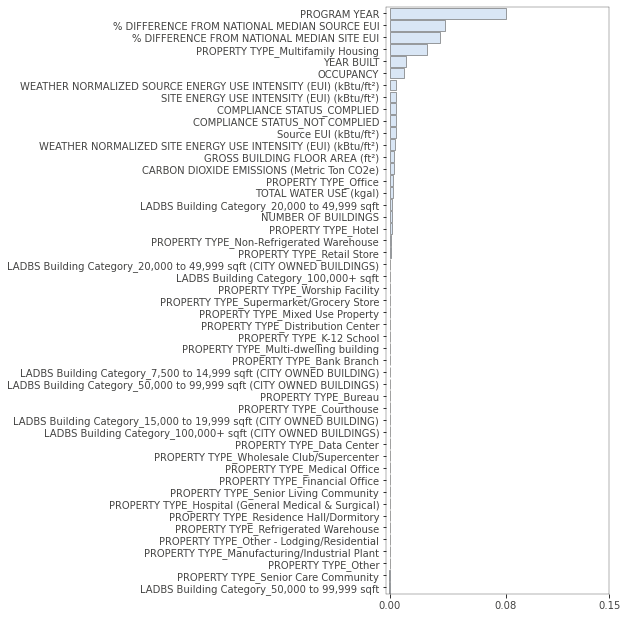

In [43]:
# Visualise PFI
viz_imp__forest_clf = rfpimp.plot_importances(imp__forest_clf)
viz_imp__forest_clf.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='GBDTClassification'></a>
## Gradient Boosting Classifier

The Gradient Boosting Decision Tree trains on residuals to improve the model:

In [44]:
# instantiate class
xgb_clf = xgb.XGBClassifier(random_state = rs)

# fit model to training data
xgb_clf.fit(train_d,train_lab) 

# apply the model to test data
xgb_clf_predictions = xgb_clf.predict(test_d)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:15:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
print("The accuracy of this classifier on the train data is: {}".format(xgb_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is: {}".format(xgb_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is: 0.9750189250567751
The accuracy of this classifier on the test data is: 0.8925056775170326


Compared to the decision tree results, the accuracy on the test data has improved and the gap between the accuracy of the training and test sets has decreased, suggesting that there is less overfitting for boosting, as expected for an ensemble method.

A confusion matrix further visualises prediction performance metrics:

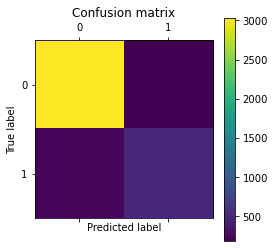

In [46]:
confusion_matrix__xgb_clf = metrics.confusion_matrix(test_lab, xgb_clf_predictions)
plt.matshow(confusion_matrix__xgb_clf)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The random forest classifier confusion matrix appears similar to the previous classifier confusion matrices in having many true negatives, some true positives, and very few false negatives and false positives.

In [47]:
metrics__xgb_clf = metrics.classification_report(test_lab, xgb_clf_predictions)
print (metrics__xgb_clf)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3225
           1       0.73      0.68      0.70       738

    accuracy                           0.89      3963
   macro avg       0.83      0.81      0.82      3963
weighted avg       0.89      0.89      0.89      3963



The precision and recall values both improve. Precision is slightly worse than decision tree and recall is slightly better than decision tree. The f1-score and accuracy are just slightly less than those for the decision tree. 

This model is too complex to visualise, but the Permutation Feature Importance (PFI) determine the importance of each feature/variable in the model:

In [48]:
# Permutation Feature Importance (PFI) 
imp__xgb_clf = rfpimp.importances(xgb_clf, test_d, test_lab) # permutation
print(imp__xgb_clf)

                                                    Importance
Feature                                                       
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI          0.133989
PROGRAM YEAR                                          0.091597
PROPERTY TYPE_Multifamily Housing                     0.017916
Source EUI (kBtu/ft²)                                 0.010093
GROSS BUILDING FLOOR AREA (ft²)                       0.010093
TOTAL WATER USE (kgal)                                0.009084
YEAR BUILT                                            0.009084
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...    0.008832
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)            0.008075
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (E...    0.006813
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)            0.006308
COMPLIANCE STATUS_COMPLIED                            0.005299
PROPERTY TYPE_Office                                  0.004794
OCCUPANCY                                             0

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


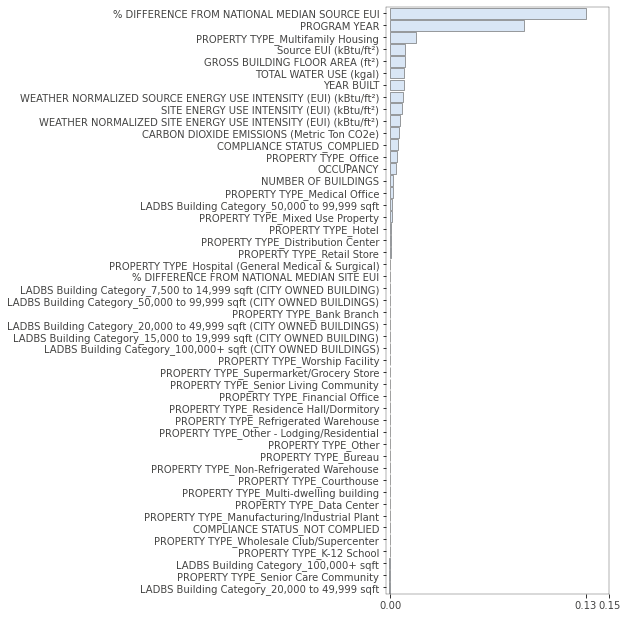

In [49]:
# Visualise PFI
viz_imp__xgb_clf = rfpimp.plot_importances(imp__xgb_clf)
viz_imp__xgb_clf.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='clf_modelcomp'></a>
## Classification Model Comparison

Compare F1 and accuracy metrics across the CART-based classification models: decision tree, random forest, and gradient boosting:

In [50]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# create a list of model names
list_name_models = ['CART', 'RF', 'GBDT']

# list the model prediction
list_clf_models = [tree_clf_predictions, forest_clf_predictions, xgb_clf_predictions]

# create an empty dictionary
dict_clf_models = dict()

# add model names and metrics to dictionary
for name, model in zip(list_name_models, list_clf_models):
    dict_clf_models[name] = [f1_score(test_lab, model), accuracy_score(test_lab, model), accuracy_score(test_lab, model)-f1_score(test_lab, model)]

# transform dict_models to dataframe
df_clf_models = pd.DataFrame.from_dict(dict_clf_models, orient='index', columns=['F1_test_score', 'Accuracy_test_score', 'Difference'])
print(df_clf_models)

      F1_test_score  Accuracy_test_score  Difference
CART       0.607646             0.852385    0.244739
RF         0.706983             0.897300    0.190317
GBDT       0.702098             0.892506    0.190408


All three classification models have lower F1 scores than Accuracy scores, reflecting the Accuracy Paradox present in the class distribution imbalance of the classification target data. The Regression Tree (CART) method has the lowest scores overall. Random Forests and Gradient Boosting Decision Trees have very similar scores, but a greater difference in F1 and Accuracy scores than the decision tree model. By a hairline, Random Forests scores better in both the F1 and Accuracy scores than Gradient Boosting. 

In [51]:
comp_clf = pd.concat([imp__tree_clf.reset_index(),
                      imp__forest_clf.reset_index(), 
                      imp__xgb_clf.reset_index()], axis=1)
arrays_clf = [np.array(['CART', 'CART', 'RF', 'RF', 'GBDT', 'GBDT']), comp_clf.columns.values]
comp_clf.columns = arrays_clf
comp_clf.head()

CART             \
                                        Feature Importance   
0  % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   0.125662   
1                                  PROGRAM YEAR   0.072168   
2    % DIFFERENCE FROM NATIONAL MEDIAN SITE EUI   0.054504   
3             PROPERTY TYPE_Multifamily Housing   0.036336   
4                         Source EUI (kBtu/ft²)   0.031289   

                                             RF             \
                                        Feature Importance   
0                                  PROGRAM YEAR   0.079233   
1  % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   0.037850   
2    % DIFFERENCE FROM NATIONAL MEDIAN SITE EUI   0.034570   
3             PROPERTY TYPE_Multifamily Housing   0.025233   
4                                    YEAR BUILT   0.011355   

                                           GBDT             
                                        Feature Importance  
0  % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   0.133989  
1                                  PROGRAM YEAR   0.091597  
2             PROPERTY TYPE_Multifamily Housing   0.017916  
3                         Source EUI (kBtu/ft²)   0.010093  
4               GROSS BUILDING FLOOR AREA (ft²)   0.010093

All three classification models exhibit similarity in their top five features of most important features. Even the decision tree scored well, although it could be prone to overfitting. With some differences in ordering, three to four of these top five features are the same between each of these models. This level of consistency likely reflects important features of the methodology that Energy Star uses to score its participants. For all three methods, "% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI" and "PROGRAM YEAR" were the top two most important features. "PROPERTY TYPE_Multifamily Housing" is the other feature that all three models have in common. Visualising "PROGRAM YEAR" (see below), the year when a building is required to comply with the EBEWE program, reveals that buildings requred to comply 2019 or later were more likely to be certification eligible buildings; perhaps this is because these are newer buildings. 

The top five for Gradient Boosting Decision Trees deviates the most from the other two models. It does not include "% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI" like the other two; instead, it uniquely includes "TOTAL WATER USE (kgal)". Even though it deviates, Gradient Boosting has performance metrics very similar to Random Forests. 

Overall, it appears that a variety of types of features are important for predicting Energy Star Certification Eligibility. These features include certain Energy Use Intensity metrics, program year, property type, building occupancy and water use. 

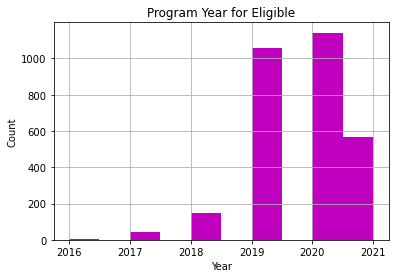

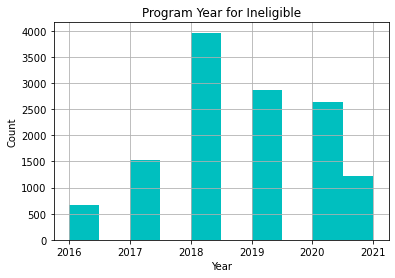

In [52]:
hot[hot['ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes']==1].hist('PROGRAM YEAR', color = 'm');
plt.title('Program Year for Eligible')
plt.xlabel('Year');
plt.ylabel('Count');

hot[hot['ENERGY STAR CERTIFICATION - ELIGIBILITY_Yes']==0].hist('PROGRAM YEAR', color = 'c');
plt.title('Program Year for Ineligible')
plt.xlabel('Year');
plt.ylabel('Count');

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='ResultsRegression'></a>
# Results & Discussion: Energy Star Score

Separate and reserve 25% of the feature data and regression target data for testing.

In [53]:
train_x, test_x, train_y, test_y = train_test_split(data_x, regr_y, random_state = rs)

<a id='RegressionTree'></a>
## Regression Tree
The Regression Tree Classifier from scikit-learn is a decision tree employing the CART algorithm. This report uses it to model the EBEWE Energy Star Score data:

In [54]:
# instantiate estimator
tree_reg = DecisionTreeRegressor(random_state=rs)

# fit model to training data
tree_reg.fit(train_x, train_y)

DecisionTreeRegressor(random_state=99)

Have a look at the R2 and RMSE metrics when model is applied to training and test sets:

In [55]:
print("R2 on the training data: {}".format(tree_reg.score(X=train_x, y=train_y)) )   
print("R2 on the testing data: {}".format(tree_reg.score(X=test_x, y=test_y)) )    
print("RMSE on the training data: {}".format(mean_squared_error(train_y, tree_reg.predict(train_x), squared=False)))
print("RMSE on the testing data: {}".format(mean_squared_error(test_y, tree_reg.predict(test_x), squared=False)))

R2 on the training data: 1.0
R2 on the testing data: 0.9944915132110709
RMSE on the training data: 0.0
RMSE on the testing data: 2.094294907173647


Both the training and testing data have almost perfect (close to 1) R2 and RMSE (close to 0) scores. This model is very strong.

In [56]:
print("Depth of the regression tree: {}".format(tree_reg.get_depth()))
print("Number of nodes of this tree: {}".format(tree_reg.get_n_leaves()))

Depth of the regression tree: 27
Number of nodes of this tree: 4065


Since this tree has more than 20 layers and hundreds of leaves, the Permutation Feature Importance (PFI) will be more useful than visualising the tree. PFI is based on how much the model error is impacted by shuffling values each feature, and it reveals the importance of specific features/variables in the model.

In [57]:
# Permutation Feature Importance (PFI) 
imp__tree_reg = rfpimp.importances(tree_reg, test_x, test_y) # permutation
print(imp__tree_reg)

                                                    Importance
Feature                                                       
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI          1.316420
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI            0.215121
PROPERTY TYPE_Multifamily Housing                     0.067992
Source EUI (kBtu/ft²)                                 0.004826
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...    0.002270
PROPERTY TYPE_Office                                  0.001896
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)            0.001868
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (E...    0.001719
TOTAL WATER USE (kgal)                                0.001072
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)            0.001071
PROGRAM YEAR                                          0.000690
PROPERTY TYPE_Hotel                                   0.000590
PROPERTY TYPE_Senior Care Community                   0.000499
PROPERTY TYPE_Refrigerated Warehouse                  0

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


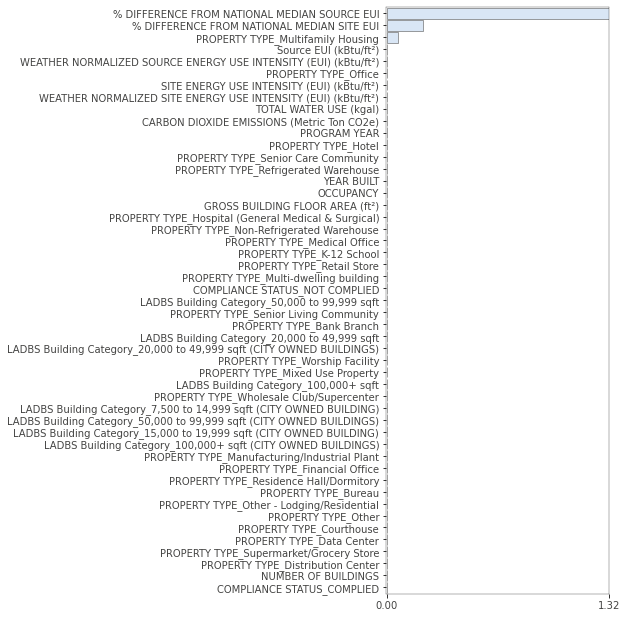

In [58]:
# Visualise PFI
viz_imp__tree_reg = rfpimp.plot_importances(imp__tree_reg)
viz_imp__tree_reg.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='RegressionForest'></a>
## Random Forest Regressor

The Random Forest Regressor from scikit-learn is a bagging ensemble method using decision trees (CART) as a basic unit. This report uses it to model the EBEWE Energy Star score data.

Below is code commented out for a cross-validated grid-search that would first identify more optimal hyperparameters; however results could not be processed due to lengthy computation time.

In [59]:
# %%time

# # values of max_depth. 6 values ranging from 10 to 100
# list_max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]

# # values of n_estimators
# list_n_estimators = [50, 100, 200, 300, 400]

# # create a grid of the two hyperparameters
# grid_hyperparameters = {'n_estimators':list_n_estimators,
#                        'max_depth': list_max_depth}

# # select the model and its hyperparameters
# forest_reg_grid = RandomForestRegressor(random_state = rs)

# # initiate and fit model
# grid_reg = model_selection.GridSearchCV(forest_reg_grid, grid_hyperparameters)
# grid_reg.fit(train_x, train_y)

In [60]:
# # query the best parameter value and its accuracy score
# print ("The best parameter value is: ")
# print (grid_clf.best_params_)
# print ("The best score is: ")
# print (grid_clf.best_score_)

Build the model:

In [61]:
# instantiate estimator
forest_reg = RandomForestRegressor(random_state = rs)
# instantiate estimator
forest_reg.fit(train_x, train_y)
# apply the model to test data

RandomForestRegressor(random_state=99)

In [62]:
print("R2 on the training data: {}".format(forest_reg.score(X=train_x, y=train_y)) )   
print("R2 on the testing data: {}".format(forest_reg.score(X=test_x, y=test_y)) )    
print("RMSE on the training data: {}".format(mean_squared_error(train_y, forest_reg.predict(train_x), squared=False)))
print("RMSE on the testing data: {}".format(mean_squared_error(test_y, forest_reg.predict(test_x), squared=False)))

R2 on the training data: 0.9995513483590802
R2 on the testing data: 0.9968495469201267
RMSE on the training data: 0.5863988589989837
RMSE on the testing data: 1.5838286275265698


Again, this model is very strong, with almost perfect R2 scores (approaching 1) and low RMSE scores (approaching 0).

This model is too complex to visualise, but the Permutation Feature Importance (PFI) determine the importance of each feature/variable in the model:

In [63]:
imp__forest_reg = rfpimp.importances(forest_reg, test_x, test_y) # permutation
print(imp__forest_reg)

                                                      Importance
Feature                                                         
% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI          6.115857e-01
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI        4.560817e-01
PROPERTY TYPE_Multifamily Housing                   6.775719e-02
Source EUI (kBtu/ft²)                               1.236961e-03
PROPERTY TYPE_Office                                9.044508e-04
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)          6.441991e-04
WEATHER NORMALIZED SITE ENERGY USE INTENSITY (E...  6.322696e-04
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...  5.632845e-04
TOTAL WATER USE (kgal)                              5.066898e-04
PROPERTY TYPE_Hotel                                 3.663489e-04
PROPERTY TYPE_Senior Care Community                 3.172894e-04
OCCUPANCY                                           3.132230e-04
PROGRAM YEAR                                        2.432709e-04
PROPERTY TYPE_Hospital (G

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


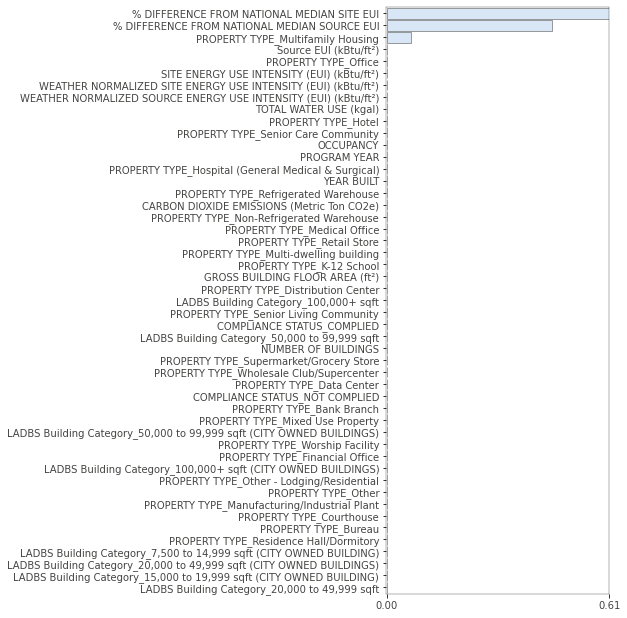

In [64]:
viz_imp__forest_reg = rfpimp.plot_importances(imp__forest_reg)
viz_imp__forest_reg.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='GBDTRegression'></a>
## Gradient Boosting Regressor

The Gradient Boosting Decision Tree trains on residuals to improve the model:

In [65]:
# instantiate estimator
xgb_reg = xgb.XGBRegressor(random_state = rs)

# fit model to training data
xgb_reg.fit(train_x, train_y)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=99,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
print("R2 on the training data: {}".format(xgb_reg.score(X=train_x, y=train_y)) )   
print("R2 on the testing data: {}".format(xgb_reg.score(X=test_x, y=test_y)) )    
print("RMSE on the training data: {}".format(mean_squared_error(train_y, xgb_reg.predict(train_x), squared=False)))
print("RMSE on the testing data: {}".format(mean_squared_error(test_y, xgb_reg.predict(test_x), squared=False)))

R2 on the training data: 0.9991174079868484
R2 on the testing data: 0.9976331975183333
RMSE on the training data: 0.8224670022438669
RMSE on the testing data: 1.3727855164649685


Again, this model is very strong, with almost perfect R2 scores (approaching 1) and low RMSE scores (approaching 0). 


This model is too complex to visualise, but the Permutation Feature Importance (PFI) determine the importance of each feature/variable in the model:

In [67]:
imp__xgb_reg = rfpimp.importances(xgb_reg, test_x, test_y) # permutation
print(imp__xgb_reg)

                                                      Importance
Feature                                                         
% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI        1.985956e+00
PROPERTY TYPE_Multifamily Housing                   5.190274e-02
Source EUI (kBtu/ft²)                               1.783969e-03
PROPERTY TYPE_Office                                1.658163e-03
SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)          1.070810e-03
PROPERTY TYPE_Non-Refrigerated Warehouse            9.191450e-04
CARBON DIOXIDE EMISSIONS (Metric Ton CO2e)          6.122351e-04
TOTAL WATER USE (kgal)                              5.841124e-04
PROGRAM YEAR                                        5.170294e-04
PROPERTY TYPE_Hotel                                 5.113917e-04
YEAR BUILT                                          5.026268e-04
WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY ...  4.983115e-04
PROPERTY TYPE_Senior Care Community                 4.639461e-04
OCCUPANCY                

/opt/conda/envs/sds2021/lib/python3.9/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


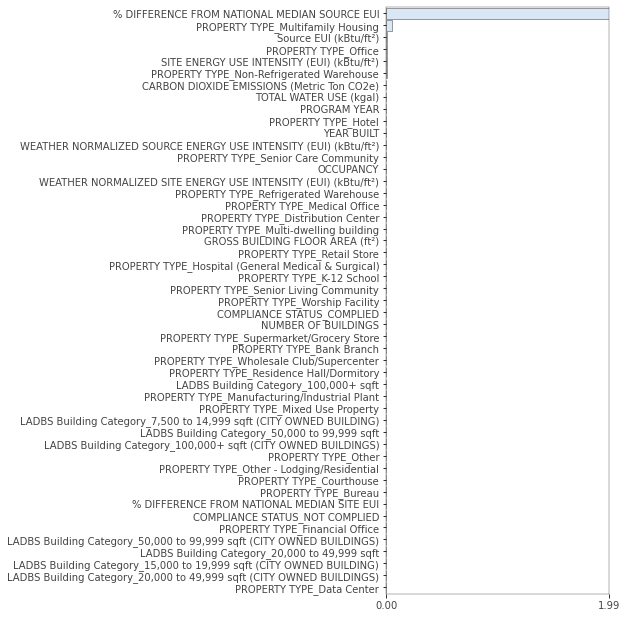

In [68]:
viz_imp__xgb_reg = rfpimp.plot_importances(imp__xgb_reg)
viz_imp__xgb_reg.view()

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='reg_modelcomp'></a>
## Regression Model Comparison

In [69]:
# create a list of model names
list_name_models = ['CART', 'RF', 'GBDT']

# list the fitted models
list_reg_models = [tree_reg, forest_reg, xgb_reg]

# create an empty dictionary
dict_reg_models = dict()

# add model names and metrics dictionary
for name, model in zip(list_name_models, list_reg_models):
    dict_reg_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y), model.score(train_x, train_y) - model.score(test_x, test_y)]

# transform dict_models to dataframe
df_reg_models = pd.DataFrame.from_dict(dict_reg_models, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
print(df_reg_models)

      R2_train_data  R2_test_data   R2_diff
CART       1.000000      0.994492  0.005508
RF         0.999551      0.996850  0.002702
GBDT       0.999117      0.997633  0.001484


All three regression models scored extremely well in R2 and RMSE metrics; R2 is be discussed in this section. All three also have low differences between their R2 values for test data and training data, indicating that overfitting is not a major issue for these models. The model that scored the highest for test data is Gradient Boosting Decision Trees, but the differences between all three models is subtle. 

In [70]:
comp_reg = pd.concat([imp__tree_reg.reset_index(),
                      imp__forest_reg.reset_index(), 
                      imp__xgb_reg.reset_index()], axis=1)
arrays_reg = [np.array(['CART', 'CART', 'RF', 'RF', 'GBDT', 'GBDT']), comp_reg.columns.values]
comp_reg.columns = arrays_reg
comp_reg.head()

CART             \
                                             Feature Importance   
0       % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   1.316420   
1         % DIFFERENCE FROM NATIONAL MEDIAN SITE EUI   0.215121   
2                  PROPERTY TYPE_Multifamily Housing   0.067992   
3                              Source EUI (kBtu/ft²)   0.004826   
4  WEATHER NORMALIZED SOURCE ENERGY USE INTENSITY...   0.002270   

                                             RF             \
                                        Feature Importance   
0    % DIFFERENCE FROM NATIONAL MEDIAN SITE EUI   0.611586   
1  % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   0.456082   
2             PROPERTY TYPE_Multifamily Housing   0.067757   
3                         Source EUI (kBtu/ft²)   0.001237   
4                          PROPERTY TYPE_Office   0.000904   

                                           GBDT             
                                        Feature Importance  
0  % DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI   1.985956  
1             PROPERTY TYPE_Multifamily Housing   0.051903  
2                         Source EUI (kBtu/ft²)   0.001784  
3                          PROPERTY TYPE_Office   0.001658  
4    SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²)   0.001071

These three regression methods exhibit similarity in their top five features of most important. With some differences in ordering, four to five of these top five features are the same between each of these models. This level of consistency likely reflects important features of the methodology that Energy Star uses to score its participants. For all three methods, "% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI" is in the top two most important features. Two other common features across all three methods are "PROPERTY TYPE_Multifamily Housing" and "Source EUI (kBtu/ft²)". 

Gradient Boosting, which was the strongest model by a small amount, deviates the most from the other two methods in its top five. It does not have "% DIFFERENCE FROM NATIONAL MEDIAN SITE EUI" in its top five; instead, it has a different energy use intensity score, SITE ENERGY USE INTENSITY (EUI) (kBtu/ft²) come fifth place. Perhaps this deviation gives it a slight edge. 

Overall, it appears that certain Energy Use Intensity metrics and property type metrics are the features that have the greatest impact on these regression models targeting Energy Star Scores. The importance of multifamily housing may be because it constitutes 62.9% of all property types (see below). In other words, this Energy Star Score calculator may be overrepresented, and therefore more accurate, for multifamily housing owners than for other owners. 

In [71]:
property_percent = data_x[data_x.columns[13:39]].sum() / data_x[data_x.columns[13:39]].sum().sum()
property_percent.sort_values(ascending = False)

PROPERTY TYPE_Multifamily Housing                      0.629447
PROPERTY TYPE_Office                                   0.164143
PROPERTY TYPE_Non-Refrigerated Warehouse               0.057595
PROPERTY TYPE_Distribution Center                      0.030785
PROPERTY TYPE_Hotel                                    0.019808
PROPERTY TYPE_Retail Store                             0.019240
PROPERTY TYPE_Medical Office                           0.016339
PROPERTY TYPE_Supermarket/Grocery Store                0.013058
PROPERTY TYPE_Worship Facility                         0.008516
PROPERTY TYPE_K-12 School                              0.007570
PROPERTY TYPE_Senior Care Community                    0.006056
PROPERTY TYPE_Refrigerated Warehouse                   0.005867
PROPERTY TYPE_Wholesale Club/Supercenter               0.004921
PROPERTY TYPE_Mixed Use Property                       0.004668
PROPERTY TYPE_Hospital (General Medical & Surgical)    0.003154
PROPERTY TYPE_Residence Hall/Dormitory  

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Conclusion'></a>
# Conclusion

Using classification and regression machine learning methods, this report has successfully created Energy Star predictive calculators for EBEWE registered buildings and detected their most influential features. As per the research objectives., the factors in the EBEWE dataset were sufficient to create these models. Classification methods were evaluated for the Energy Star Certification Eligibility calculator. The classification method with the strongest metrics that should be used for the calculator was Random Forests, which was optimised for a limited range of hyperparameters. Regression methods were evaluated for an Energy Star Score Prediction Calculator. The regression method with the strongest metrics that should be used for the calculator was Gradient Boosting Decision Trees. Further model improvements may involve further optimising hyperparameters for any of the existing models or using other methods, such as Lasso Regression, Logistic Regression (for classification), or neural networks, since this report only tree-based models. The regression model already performs very well, so future studies may focus on improving the classification model and its problem of the Accuracy Paradox.

In both calculators, "% DIFFERENCE FROM NATIONAL MEDIAN SOURCE EUI" was often the most important feature. According to Energy Star, Energy Use Intensity (EUI) is a key building metric equal to total annual energy consumed divided by total gross floor area ("What is Energy Use Intensity (EUI)?"). This finding is unsurprising given that EUI is such an encompassing metric and that Energy Star Scores are calculated based on national medians. In fact, the EPA recommends source energy as a metric over site energy, since source energy encompasses raw fuel that may be lost through intermediate processes such as transmission, while site energy only corresponds to energy bills. Interesting, in both classification and regression methods, Gradient Boosting Regression Trees deviated from other methods by omitting forms of site EUI in its top five features. Further studies may optimise gradient boosting hyperparameters for interest in its unique insights and high performance. 

The best use case for these Energy Star calculators is for EBEWE-registered building owners to simulate changes in their Energy Star Score and certification eligibilty given experimental changes in their energy use and building use variables. Moreover, non-EBEWE-registered buildings, such as buildings smaller than the EBEWE size requirements, may also use this calculator, since it is inclusive of building size or property type. These calculators enable City and private owners of large buildings to have more options and perspectives in understanding the energy use efficiency of their properties. 

[1. Title](#Title)  |  [2. Introduction](#Introduction)  |  [2.0.1 Research Question](#Research_Question)  |  [3. Methodology](#Methodology)  |  [4. Preprocessing](#Preprocessing)  |  [5. Presentation of Data](#Presentation_of_Data)

[6. Results & Discussion: Certification Eligibility Classification](#ResultsClassification)  |  [6.1 Tree](#ClassificationTree) ~ [6.2 Forest](#ClassificationForest) ~ [6.3 Boosting](#GBDTClassification) ~ [6.4 Comparison](#clf_modelcomp)

[7. Results & Discussion: Energy Star Score Regression](#ResultsRegression)  |  [7.1 Tree](#RegressionTree) ~ [7.2 Forest](#RegressionForest) ~ [7.3 Boosting](#GBDTRegression) ~ [6.4 Comparison](#reg_modelcomp)

[8. Conclusion](#Conclusion)  |  [9. Bibliography](#Bibliography)

<a id='Bibliography'></a>
# Bibliography

1.10. Decision Trees (no date) scikit-learn. Available at: https://scikit-learn/stable/modules/tree.html (Accessed: 29 April 2022).

Abdallah, M., Muddana, L. and Clevenger, C. (2020) ‘Upgrading Large Existing Buildings to Maximize Their Sustainability’, Journal of Architectural Engineering, 26(1), p. 04019029. doi:10.1061/(ASCE)AE.1943-5568.0000376.

Adekanye, O.G., Davis, A. and Azevedo, I.L. (2020) ‘Federal policy, local policy, and green building certifications in the U.S.’, Energy and Buildings, 209, p. 109700. doi:10.1016/j.enbuild.2019.109700.

‘ebewecomplianceinstructions2021.pdf’ (no date). Available at: https://www.ladbs.org/docs/default-source/forms/ebewecomplianceinstructions2021.pdf?sfvrsn=16f7cd53_18 (Accessed: 29 April 2022).

ENERGY STAR Portfolio Manager (no date) Glossary. Available at: https://portfoliomanager.energystar.gov/pm/glossary#EnergyStarScore (Accessed: 29 April 2022).

ENERGY STAR Portfolio Manager Portfolio Manager: What data is required to benchmark your property? (no date). Available at: https://portfoliomanager.energystar.gov/pm/dataCollectionWorksheet?dcw.data=%7B%22country%22:%22US%22,%22propertyUsages%22:%5B%7B%22propertyUse%22:%22OTHER%22,%22useType%22:%22OTHER%22%7D%5D%7D (Accessed: 29 April 2022).

How the 1-100 ENERGY STAR Score is Calculated (no date). Available at: https://www.energystar.gov/buildings/benchmark/understand_metrics/how_score_calculated (Accessed: 29 April 2022).
Jena, M. and Dehuri, S. (2020) ‘DecisionTree for Classiﬁcation and Regression: A State-of-the Art Review’, Informatica, 44(4). doi:10.31449/inf.v44i4.3023.

Jin, X. et al. (2022) ‘GEIN: An interpretable benchmarking framework towards all building types based on machine learning’, Energy and Buildings, 260, p. 111909. doi:10.1016/j.enbuild.2022.111909.

LA County Dept. of Regional Planning (no date) ‘ZIP Codes | LAC Open Data’. Available at: https://data.lacounty.gov/Geospatial/ZIP-Codes/65v5-jw9f (Accessed: 29 April 2022).

Leskinen, N., Vimpari, J. and Junnila, S. (2020) ‘A Review of the Impact of Green Building Certification on the Cash Flows and Values of Commercial Properties’, Sustainability, 12(7), p. 2729. doi:10.3390/su12072729.

Los Angeles Department of Building and Safety (LADBS) (2022) Existing Buildings Energy & Water Efficiency (EBEWE) Program | Los Angeles - Open Data Portal. Available at: https://data.lacity.org/City-Infrastructure-Service-Requests/Existing-Buildings-Energy-Water-Efficiency-EBEWE-P/9yda-i4ya (Accessed: 29 April 2022).

Qiu, Y. and Kahn, M.E. (2019) ‘Impact of voluntary green certification on building energy performance’, Energy Economics, 80, pp. 461–475. doi:10.1016/j.eneco.2019.01.035.

Robinson, C. et al. (2017) ‘Machine learning approaches for estimating commercial building energy consumption’, Applied Energy, 208, pp. 889–904. doi:10.1016/j.apenergy.2017.09.060.

Understand Portfolio Manager Metrics (no date). Available at: https://www.energystar.gov/buildings/benchmark/understand_metrics (Accessed: 29 April 2022).

United Nations Environment Programme (2021) 2021 Global Status Report for Buildings and Construction. Available at: https://globalabc.org/resources/publications/2021-global-status-report-buildings-and-construction (Accessed: 28 April 2022).

What is Energy Use Intensity (EUI)? (no date). Available at: https://www.energystar.gov/buildings/benchmark/understand_metrics/what_eui (Accessed: 3 May 2022).